In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D, LSTM ,Dropout
from keras.layers.convolutional import Conv1D, Conv2D
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile
import pandas as pd

Using TensorFlow backend.


In [2]:
c=mdb.get_files_for_instrument('flute')
for i in c:
    print(i)

C:\Users\noluc\OneDrive\CSULB\Spring_2019\CECS 551\Audio\JoelHelander_Definition\JoelHelander_Definition_STEMS\JoelHelander_Definition_STEM_09.wav
C:\Users\noluc\OneDrive\CSULB\Spring_2019\CECS 551\Audio\JoelHelander_Definition\JoelHelander_Definition_STEMS\JoelHelander_Definition_STEM_10.wav
C:\Users\noluc\OneDrive\CSULB\Spring_2019\CECS 551\Audio\MatthewEntwistle_AnEveningWithOliver\MatthewEntwistle_AnEveningWithOliver_STEMS\MatthewEntwistle_AnEveningWithOliver_STEM_12.wav
C:\Users\noluc\OneDrive\CSULB\Spring_2019\CECS 551\Audio\MatthewEntwistle_FairerHopes\MatthewEntwistle_FairerHopes_STEMS\MatthewEntwistle_FairerHopes_STEM_14.wav
C:\Users\noluc\OneDrive\CSULB\Spring_2019\CECS 551\Audio\MusicDelta_Beethoven\MusicDelta_Beethoven_STEMS\MusicDelta_Beethoven_STEM_06.wav
C:\Users\noluc\OneDrive\CSULB\Spring_2019\CECS 551\Audio\MusicDelta_Beethoven\MusicDelta_Beethoven_STEMS\MusicDelta_Beethoven_STEM_07.wav
C:\Users\noluc\OneDrive\CSULB\Spring_2019\CECS 551\Audio\MusicDelta_InTheHallofthe

# Load the mix

In [3]:
multitracks = mdb.load_multitracks(["Phoenix_ColliersDaughter", "Phoenix_ScotchMorris"])

In [4]:
mix = next(multitracks)

In [5]:
sample_rate, mix_audio = wavfile.read(mix.mix_path)
mix_audio = mix_audio.mean(1)
mix_audio = mix_audio[sample_rate*8:int(-sample_rate*1.5)]

In [6]:
samples_per_period = 256
overlap = int(samples_per_period/2)

In [7]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [8]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))

# Load the Flute

In [9]:
mix.raw_instruments

['Main System',
 'Main System',
 'acoustic guitar',
 'electric bass',
 'flute',
 'violin']

In [10]:
flutes = mdb.get_files_for_instrument("flute", [mix])

In [11]:
flute = next(flutes)

In [12]:
sample_rate, flute_audio = wavfile.read(flute)
flute_audio = flute_audio.mean(1)
flute_audio = flute_audio[sample_rate*8:int(-sample_rate*1.5)]

In [13]:
freqs, times, s_flute = signal.stft(flute_audio, fs=sample_rate, nfft=samples_per_period, 
                                           noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_flute = s_flute[:-1,:]

In [14]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_flute)))

## Create a mask for the flute

In [15]:
mask_flute = s_flute / (s_flute + s_mix + 1e-9)
print (mask_flute.shape)

(128, 62416)


In [16]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(mask_flute)))

# Prepare the training data

In [17]:
num_test  = int((sample_rate * 10)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

60694 1722


In [18]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape


(60694, 128, 2)

In [19]:
flute_train = mask_flute.T[:num_train,:,np.newaxis]
flute_train = np.concatenate((flute_train.real, flute_train.imag), axis=-1)
flute_train.shape

(60694, 128, 2)

In [20]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(1722, 128, 2)

In [21]:
flute_test = mask_flute.T[-num_test:,:,np.newaxis]
flute_test = np.concatenate((flute_test.real, flute_test.imag), axis=-1)
flute_test.shape



(1722, 128, 2)

In [23]:
model = Sequential()

model.add(Conv1D(16, 2, padding="same", input_shape=mix_train.shape[1:], activation="relu", name="Conv1D_1"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_1"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_2"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_2"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_3"))
model.add(MaxPooling1D(2, padding="same", name="MaxPooling_3"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_4"))
model.add(UpSampling1D(2, name="UpSampling_1"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_5"))
model.add(UpSampling1D(2, name="UpSampling_2"))

model.add(Conv1D(16, 2, padding="same",  activation="relu", name="Conv1D_6"))
model.add(UpSampling1D(2, name="UpSampling_3"))

model.add(Conv1D(2, 2, padding="same",  name="Conv1D_7"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 128, 16)           80        
_________________________________________________________________
MaxPooling_1 (MaxPooling1D)  (None, 64, 16)            0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 64, 16)            528       
_________________________________________________________________
MaxPooling_2 (MaxPooling1D)  (None, 32, 16)            0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 32, 16)            528       
_________________________________________________________________
MaxPooling_3 (MaxPooling1D)  (None, 16, 16)            0         
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 16, 16)            528       
__________

In [22]:
regressor = Sequential() 
regressor.add(LSTM(units = 90, return_sequences=True, input_shape = mix_train.shape[1:])) 
regressor.add(Dropout(0.4))
    
regressor.add(LSTM(units = 90, return_sequences=True)) 
regressor.add(Dropout(0.4))
regressor.add(LSTM(units =90, return_sequences=True)) 
regressor.add(Dropout(0.4))
    
regressor.add(LSTM(units = 90, return_sequences=True)) 
regressor.add(Dropout(0.4))
     
regressor.add(LSTM(units = 90, return_sequences=True)) 
regressor.add(Dropout(0.4))
    
regressor.add(Dense(units=2))

regressor.summary()
    

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 90)           33480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 90)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 90)           65160     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 90)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128, 90)           65160     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 90)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128, 90)           65160     
__________

In [23]:
regressor.compile('adam', loss='mean_squared_error', metrics=['accuracy'])

In [24]:
history = regressor.fit(mix_train, flute_train, batch_size=200, epochs=10)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/10
60694/60694 [==============================] - 229s 4ms/step - loss: 4.1481 - acc: 0.8092
Epoch 2/10
60694/60694 [==============================] - 226s 4ms/step - loss: 4.1464 - acc: 0.8106
Epoch 3/10
60694/60694 [==============================] - 225s 4ms/step - loss: 4.1457 - acc: 0.8105
Epoch 4/10
60694/60694 [==============================] - 225s 4ms/step - loss: 4.1448 - acc: 0.8102
Epoch 5/10
60694/60694 [==============================] - 226s 4ms/step - loss: 4.1434 - acc: 0.8103
Epoch 6/10
60694/60694 [==============================] - 226s 4ms/step - loss: 4.1417 - acc: 0.8104
Epoch 7/10
60694/60694 [==============================] - 225s 4ms/step - loss: 4.1410 - acc: 0.8104
Epoch 8/10
60694/60694 [==============================] - 226s 4ms/step - loss: 4.1408 - acc: 0.8104
Epoch 9/10
60694/60694 [==============================] - 226s 4ms/step - loss: 4.1403 - acc: 0.8103
Epoch 10/10
60694/60694 [==============================] - 226s 4ms/step - loss: 4.1399 - a

In [27]:
results = regressor.evaluate(mix_test, flute_test)

print(regressor.metrics_names)
print(results)

1722/1722 [==============================] - 15s 9ms/step
['loss', 'acc']
[0.5107896550884091, 0.8174315837063717]


# Results

In [323]:
mask_prediction = model.predict(mix_test)
mask_prediction.shape

(1722, 128, 2)

In [324]:
mask_prediction = np.sqrt((mask_prediction**2).sum(-1)).T

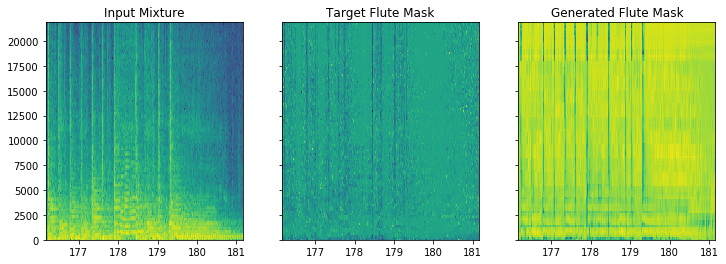

In [325]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target Flute Mask")
ax3.set_title("Generated Flute Mask")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(mask_flute[:,-num_test:])))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(mask_prediction))

In [326]:
target = s_mix[:,-num_test:] * mask_flute[:,-num_test:]

In [327]:
prediction = s_mix[:,-num_test:] * mask_prediction

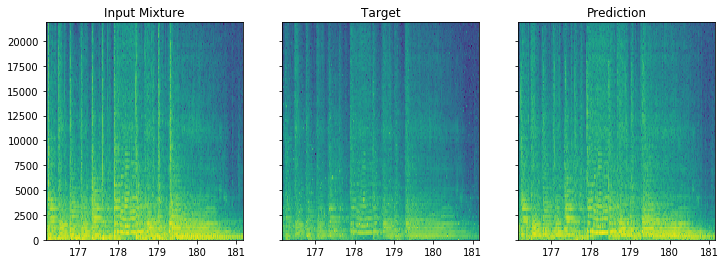

In [328]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [329]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)

In [330]:
wavfile.write("fcn_model_flute_prediction.wav", sample_rate, predicted_audio.astype(np.int16))

In [331]:
_, target_audio = signal.istft(target, fs=sample_rate)

In [332]:
wavfile.write("fcn_model_flute_target.wav", sample_rate, target_audio.astype(np.int16))

In [333]:
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

In [334]:
wavfile.write("fcn_model_original.wav", sample_rate, mix_audio.astype(np.int16))